In [129]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from mobius import ForceField, VirtualTarget

In [11]:
data = []

with open('binding_data_2013/bdata.20130222.mhci.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:]:
        sline = line.split()
        data.append((sline[0], sline[1], int(sline[2]), sline[3], sline[4], float(sline[5])))

columns = ['species', 'mhc_allele', 'length', 'sequence', 'inequality', 'affinity_binding']
mhci = pd.DataFrame(data=data, columns=columns)
mhci.to_csv('binding_data_2013/bdata.20130222.mhci.csv', index=False)

In [17]:
for name, group in mhci[mhci['species'] == 'human'].groupby('mhc_allele'):
    print(name, len(group))

HLA-A*01:01 4792
HLA-A*02:01 12160
HLA-A*02:02 4155
HLA-A*02:03 6303
HLA-A*02:04 4
HLA-A*02:05 75
HLA-A*02:06 5628
HLA-A*02:07 80
HLA-A*02:10 18
HLA-A*02:11 1085
HLA-A*02:12 1183
HLA-A*02:16 921
HLA-A*02:17 346
HLA-A*02:19 1246
HLA-A*02:50 135
HLA-A*03:01 7358
HLA-A*03:02 26
HLA-A*03:19 30
HLA-A*11:01 6399
HLA-A*11:02 14
HLA-A*23:01 2641
HLA-A*24:02 3280
HLA-A*24:03 1381
HLA-A*25:01 960
HLA-A*26:01 4535
HLA-A*26:02 643
HLA-A*26:03 537
HLA-A*29:02 2789
HLA-A*30:01 2925
HLA-A*30:02 2057
HLA-A*31:01 5713
HLA-A*32:01 1136
HLA-A*32:07 88
HLA-A*32:15 74
HLA-A*33:01 3597
HLA-A*66:01 219
HLA-A*68:01 3795
HLA-A*68:02 5545
HLA-A*68:23 82
HLA-A*69:01 2565
HLA-A*74:01 15
HLA-A*80:01 1171
HLA-A1 1
HLA-A11 74
HLA-A2 63
HLA-A24 2
HLA-A26 4
HLA-A3 6
HLA-A3/11 2
HLA-B*07:02 4642
HLA-B*08:01 3538
HLA-B*08:02 1020
HLA-B*08:03 470
HLA-B*14:01 42
HLA-B*14:02 341
HLA-B*15:01 4448
HLA-B*15:02 164
HLA-B*15:03 701
HLA-B*15:09 832
HLA-B*15:17 1447
HLA-B*15:42 364
HLA-B*18:01 2832
HLA-B*27:01 4
HLA-B*27:02 8
HLA

# HLA-A*02:01

(7.0, 15.0)

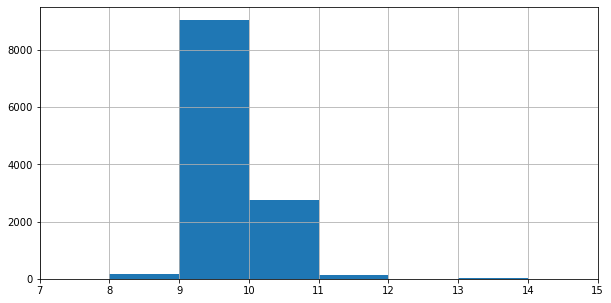

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['length'].hist(ax=ax, bins=range(7, 15))
ax.set_xlim([7, 15])

<AxesSubplot:>

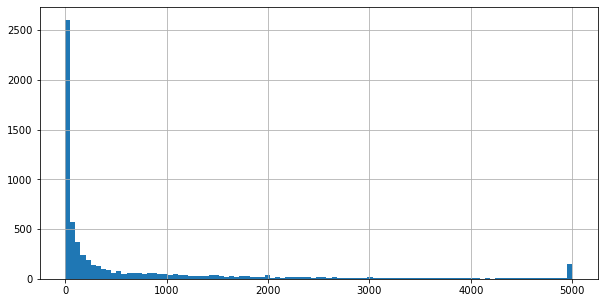

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=ax, bins=np.linspace(0, 5000, 100))

In [237]:
selected = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (mhci['length'] == 9) &
                (~selected['affinity_binding'].isin([20000, 69444.44444, 78125])) &
                (selected['affinity_binding'] < 5000)]
X_train, X_test, y_train, y_test = train_test_split(selected['sequence'], selected['affinity_binding'], test_size=0.33, random_state=42)

In [238]:
def transform_sequences(sequences):
    ff = ForceField()
    p = ff.parameters()
    
    transformed_sequences = []
    
    for seq in sequences:
        tmp = []
        for aa in seq:
            h, v = p[p['AA1'] == aa][['hydrophilicity', 'volume']].tolist()[0]
            tmp.extend([float(1 - h), float(v)])
        
        transformed_sequences.append(tmp)
        
    return np.array(transformed_sequences)

In [239]:
X_train_transformed = torch.from_numpy(transform_sequences(X_train)).float()
X_test_transformed = torch.from_numpy(transform_sequences(X_test)).float()

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [240]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [241]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

In [242]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

In [263]:
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=training_iter):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %02d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        
        optimizer.step()

In [264]:
train(model, likelihood, X_train_transformed, y_train, training_iter)

Iter 01/50 - Loss: 13309.568   lengthscale: 0.438   noise: 20.217
Iter 02/50 - Loss: 13313.755   lengthscale: 0.404   noise: 20.317
Iter 03/50 - Loss: 13184.959   lengthscale: 0.428   noise: 20.417
Iter 04/50 - Loss: 13132.148   lengthscale: 0.452   noise: 20.517
Iter 05/50 - Loss: 13093.079   lengthscale: 0.462   noise: 20.617
Iter 06/50 - Loss: 13019.836   lengthscale: 0.458   noise: 20.717
Iter 07/50 - Loss: 12937.281   lengthscale: 0.447   noise: 20.817
Iter 08/50 - Loss: 12870.089   lengthscale: 0.434   noise: 20.917
Iter 09/50 - Loss: 12819.788   lengthscale: 0.423   noise: 21.017
Iter 10/50 - Loss: 12769.217   lengthscale: 0.419   noise: 21.116
Iter 11/50 - Loss: 12707.466   lengthscale: 0.420   noise: 21.215
Iter 12/50 - Loss: 12639.482   lengthscale: 0.426   noise: 21.314
Iter 13/50 - Loss: 12575.461   lengthscale: 0.434   noise: 21.412
Iter 14/50 - Loss: 12520.113   lengthscale: 0.442   noise: 21.510
Iter 15/50 - Loss: 12469.459   lengthscale: 0.448   noise: 21.609
Iter 16/50

In [267]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

In [268]:
observed_pred = predict(model, likelihood, X_test_transformed)

In [275]:
observed_pred.mean
#observed_pred.variance
#observed_pred.covariance_matrix

tensor([567.2508, 174.3178, 776.4401,  ..., 248.9178, 909.9118,  66.6801])

In [286]:
def plot(y_test, observed_pred):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 10))

        # Get upper and lower confidence bounds
        #lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        #ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.scatter(y_test, observed_pred)
        # Shade between the lower and upper confidence bounds
        #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        #ax.set_ylim([-3, 3])
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_xlim([-500, 6000])
        ax.set_ylim([-500, 6000])
        
        ax.set_xlabel('Experimental values', fontsize=20)
        ax.set_ylabel('Predicted values', fontsize=20)

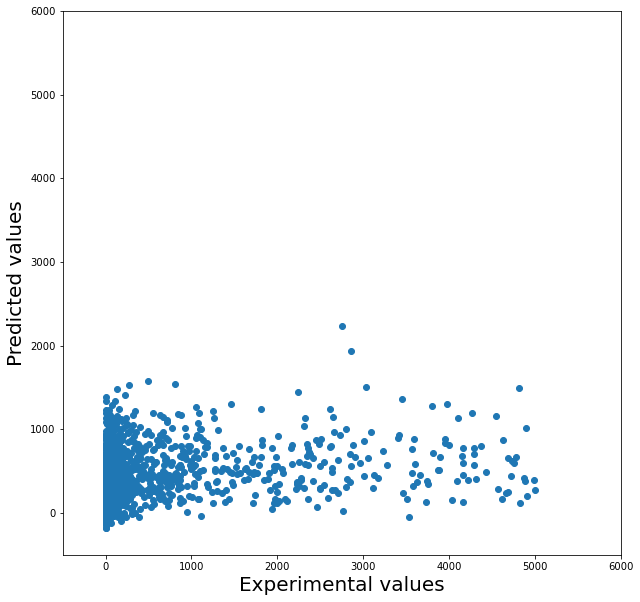

In [287]:
plot(y_test, observed_pred.mean.numpy())